# Whale Network Analysis - Not kuramoto


In [1]:
import pandas as pd
import networkx as nx # networkx for making networks
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
%matplotlib inline

In [5]:
# Load data
df = pd.read_csv("PrepData.csv")
# Just change NaN in coloumn to initation calls. Happens at start of each dataset. Otherwise there are no NaN
df["CallType"] = df["CallType"].fillna("InitiationCall") 

### 1. Create networks for each group (G1, G2, G3)

In [ ]:
# Create dictionaries to store the looped graphs and central whales fr each group
group_graphs = {}
# Stores the "centrality" scores ie. top whale per group
group_central_whales = {}

# Loop through each whale group (G1, G2, G3)
for group_id, df_group in df.groupby("Group"):
    
    # Keeps track of how often one animal (initiator) responds to another (responder).
    edge_counts = Counter()

    # Group by 'bout' to identify interaction episodes
    for bout_id, group in df_group.groupby("bout"):
        group_sorted = group.sort_values("StartTime")

        # Identify the initiator of the bout
        initiator_row = group_sorted[group_sorted["CallType"] == "InitiationCall"]
        responders = group_sorted[group_sorted["CallType"] == "ResponseCall"]

        # Add edges from the initiator to each responder in the same bout
        if not initiator_row.empty:
            initiator = initiator_row.iloc[0]["WhaleID"]
            for _, responder_row in responders.iterrows():
                responder = responder_row["WhaleID"]
                if pd.notna(responder) and initiator != responder:
                    edge_counts[(initiator, responder)] += 1

    # Build a directed graph and add weighted edges
    G = nx.DiGraph()
    for (u, v), w in edge_counts.items():
        G.add_edge(u, v, weight=w)

    group_graphs[group_id] = G

    # Compute node strengths (total in + out weights) for centrality
    node_strength = {}
    for node in G.nodes():
        in_strength = sum(G[u][node]['weight'] for u in G.predecessors(node))
        out_strength = sum(G[node][v]['weight'] for v in G.successors(node))
        node_strength[node] = in_strength + out_strength

    # Identify the most central whale (highest total strength)
    central_whale = max(node_strength, key=node_strength.get) if node_strength else None
    group_central_whales[group_id] = (node_strength, central_whale)

## 🎯 Step 4: Visualize Interaction Networks

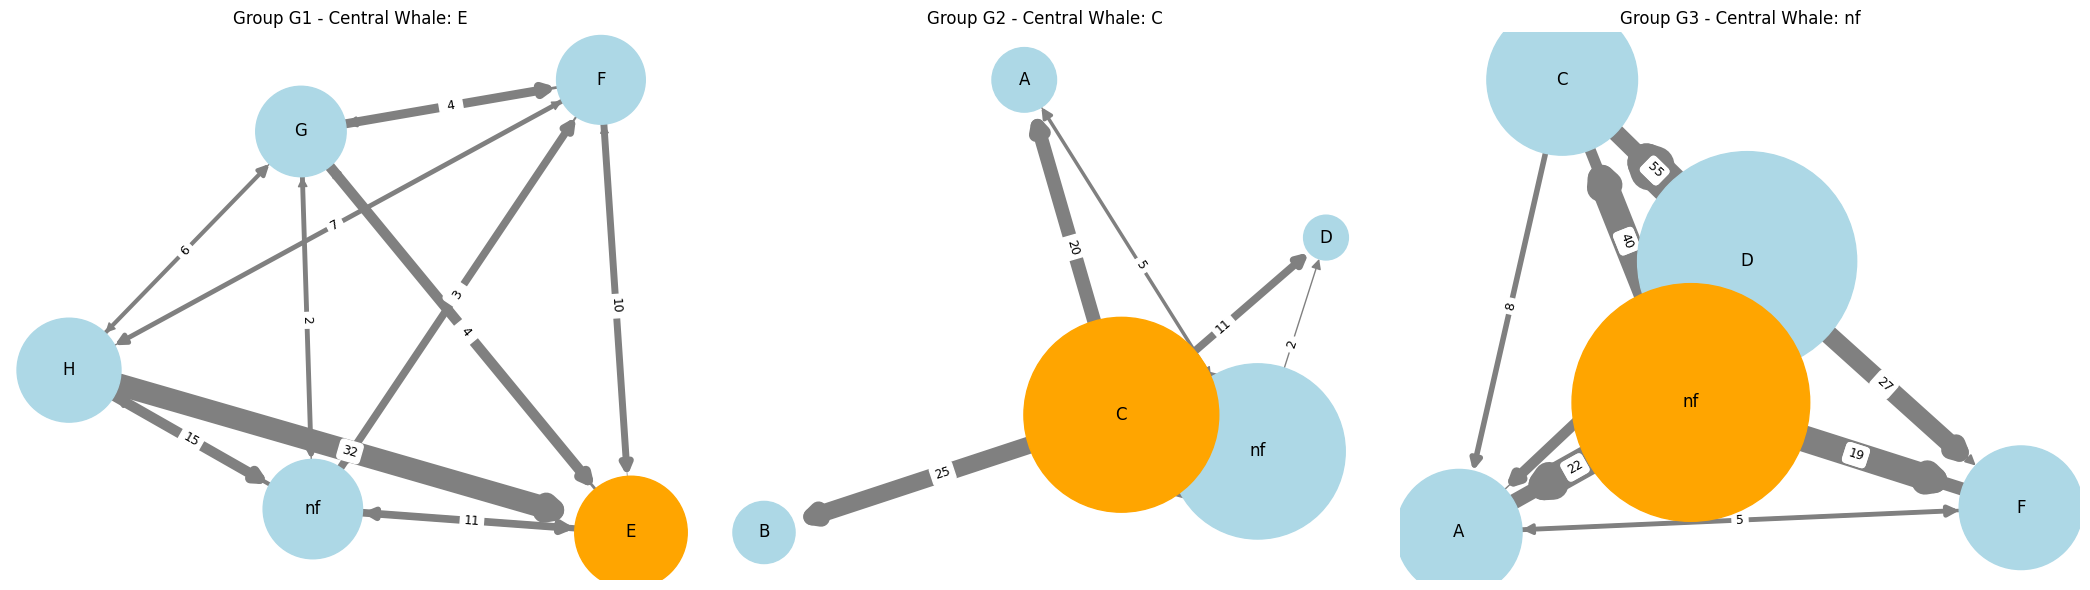

In [4]:
# Draw each group's network
# Node size reflects total strength, orange node is the most central whale
fig, axes = plt.subplots(1, 3, figsize=(21, 6))

for ax, (group_id, G) in zip(axes, group_graphs.items()):
    strength_dict, central_whale = group_central_whales[group_id]
    # Use spring layout and space nodes out more for clarity (k controls spacing)
    k_value = 1.2 if group_id == "G1" else 2.5
    pos = nx.spring_layout(G, seed=42, k=k_value)

    node_sizes = [strength_dict.get(node, 1) * 80 for node in G.nodes()]
    node_colors = ['orange' if node == central_whale else 'lightblue' for node in G.nodes()]
    weights = [G[u][v]['weight'] * 0.5 for u, v in G.edges()]

    nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=node_sizes,
            edge_color='gray', width=weights, arrowsize=15, ax=ax)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, ax=ax, font_size=9)
    ax.set_title(f"Group {group_id} - Central Whale: {central_whale}")

plt.tight_layout()
plt.show()

## 🤝 Step 5: Extract Dyadic Interaction Statistics
We identify all initiator → responder pairs and count how many times each interaction occurs across bouts.

In [5]:
# Store each interaction as a row in a list
dyadic_stats = []

# Process by group (G1, G2, G3)
for group_id, df_group in df.groupby("Group"):
    df_group_clean = df_group.dropna(subset=["WhaleID", "CallType"])

    for bout_id, group in df_group_clean.groupby("bout"):
        group_sorted = group.sort_values("StartTime")
        initiator_row = group_sorted[group_sorted["CallType"] == "InitiationCall"]
        responders = group_sorted[group_sorted["CallType"] == "ResponseCall"]

        if not initiator_row.empty:
            initiator = initiator_row.iloc[0]["WhaleID"]
            for _, responder_row in responders.iterrows():
                responder = responder_row["WhaleID"]
                if pd.notna(responder) and initiator != responder:
                    dyadic_stats.append({
                        "Group": group_id,
                        "Initiator": initiator,
                        "Responder": responder
                    })

# Convert to a DataFrame and count unique dyads
dyad_df = pd.DataFrame(dyadic_stats)
dyad_summary = dyad_df.groupby(["Group", "Initiator", "Responder"]).size().reset_index(name="CallCount")
dyad_summary.head()

,Group,Initiator,Responder,CallCount
0,G1,E,F,1
1,G1,E,G,4
2,G1,E,nf,9
3,G1,F,E,10
4,G1,F,G,4


## 🌡️ Step 6: Visualize Dyadic Networks and Heatmaps
We now visualize pairwise interaction strengths with:
- Directed network graphs (Initiator → Responder)
- Heatmaps showing call frequencies

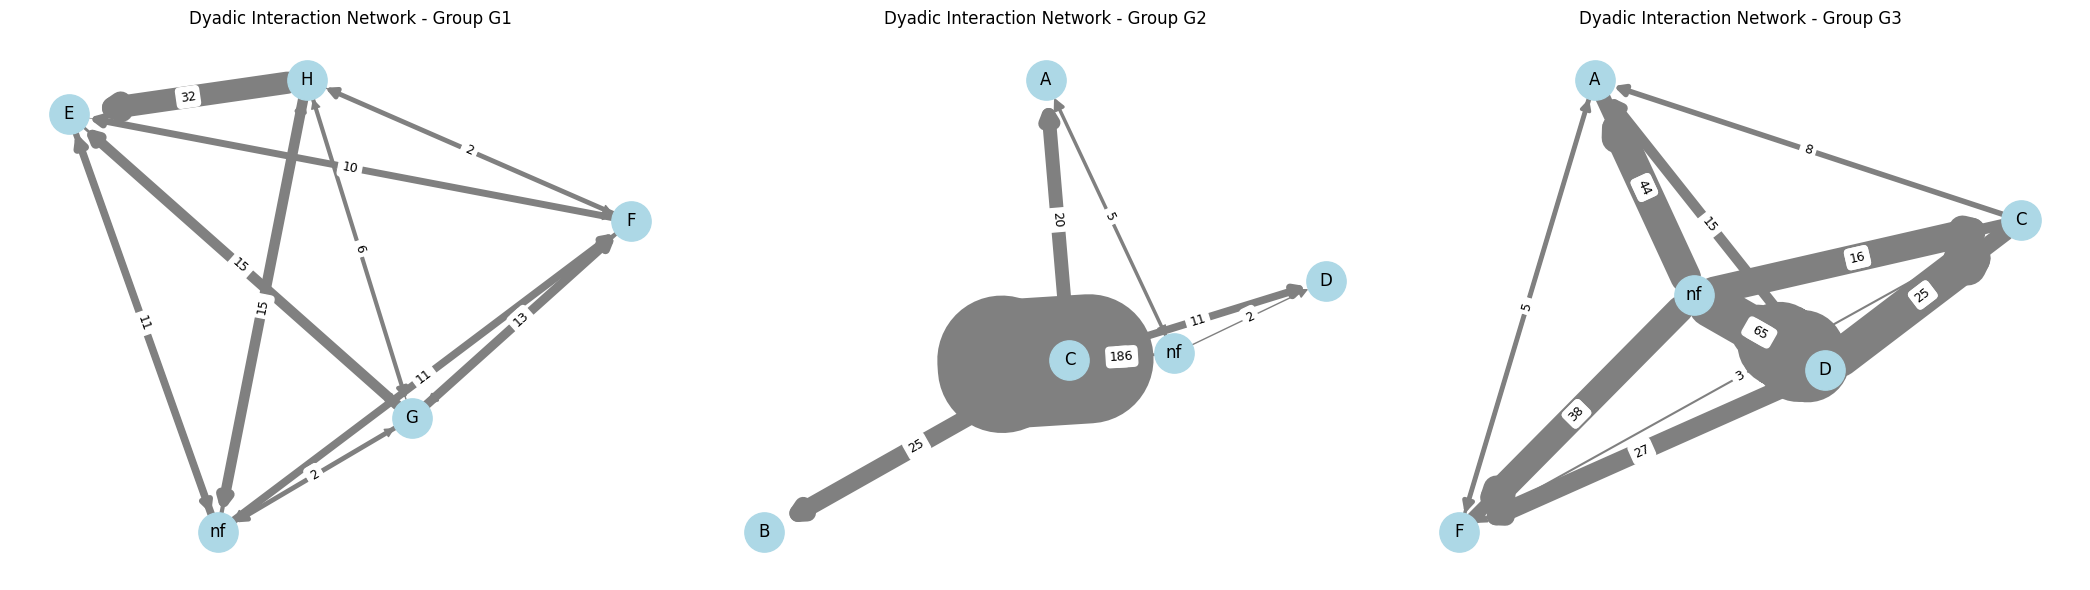

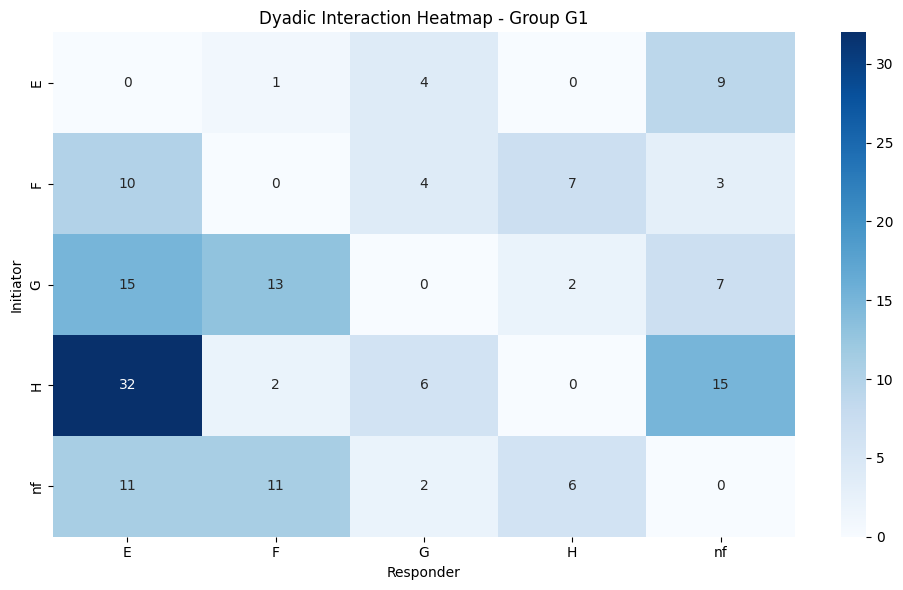

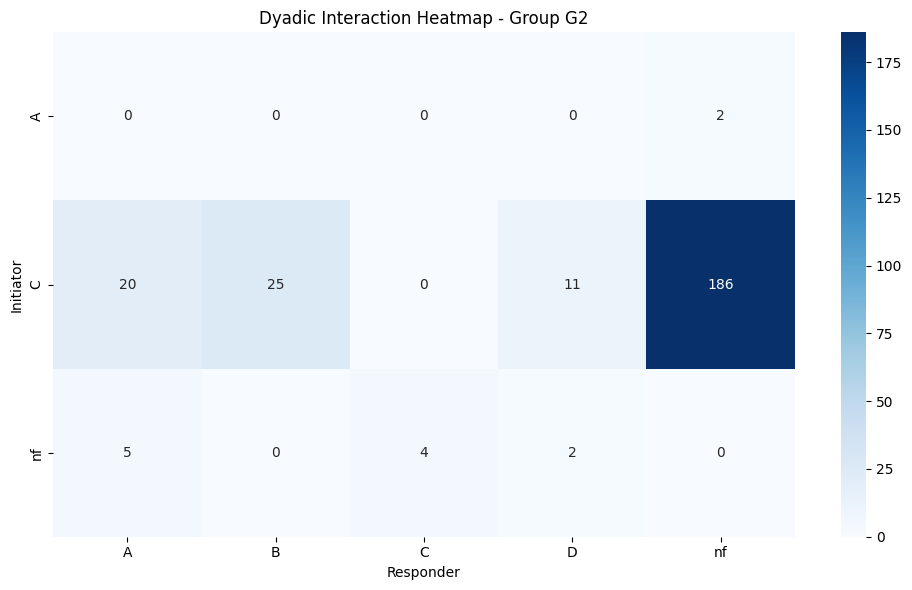

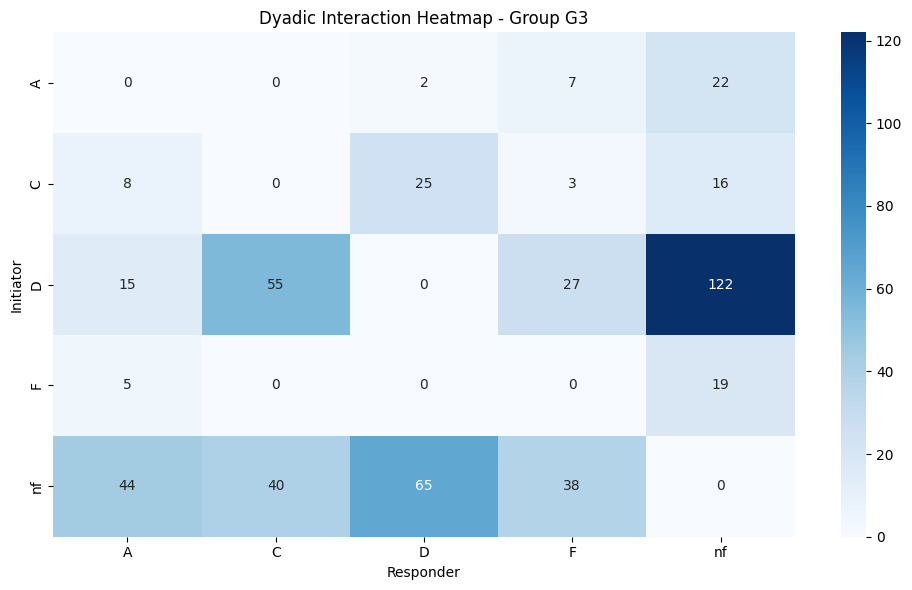

In [6]:
# Create network and heatmap for each group based on dyadic interactions
dyad_graphs = {}

# Build directed graphs from dyad counts
for group_id, group_data in dyad_summary.groupby("Group"):
    G = nx.DiGraph()
    for _, row in group_data.iterrows():
        G.add_edge(row["Initiator"], row["Responder"], weight=row["CallCount"])
    dyad_graphs[group_id] = G

# Visualize dyadic interaction networks
fig, axes = plt.subplots(1, 3, figsize=(21, 6))

for ax, (group_id, G) in zip(axes, dyad_graphs.items()):
    pos = nx.spring_layout(G, seed=42, k=1.8)
    weights = [G[u][v]['weight'] * 0.5 for u, v in G.edges()]
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=800,
            edge_color='gray', width=weights, arrowsize=15, ax=ax)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, ax=ax, font_size=9)
    ax.set_title(f"Dyadic Interaction Network - Group {group_id}")

plt.tight_layout()
plt.show()

# Generate heatmaps
for group_id, group_data in dyad_summary.groupby("Group"):
    pivot = group_data.pivot(index="Initiator", columns="Responder", values="CallCount").fillna(0)
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot, annot=True, fmt=".0f", cmap="Blues")
    plt.title(f"Dyadic Interaction Heatmap - Group {group_id}")
    plt.xlabel("Responder")
    plt.ylabel("Initiator")
    plt.tight_layout()
    plt.show()